In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from typing import Iterable

In [2]:
np.random.seed(0)

In [3]:
def make_data(name: str, path: str, scale: bool=True):
    data_all = []
    for dtsplit in ['train', 'valid', 'test']:
        dtpath = os.path.join(path, f"{name}_{dtsplit}.csv")
        data = pd.read_csv(dtpath).to_numpy()
        if scale:
            _max, _min = np.max(data[:, 1:], axis=0, keepdims=True), np.min(data[:, 1:], axis=0, keepdims=True)
            data[:, 1:] = (data[:, 1:] - _min) / (_max - _min)
        data_all.append(data)
    return data_all

def accuracy_score(preds: np.ndarray, labels: np.ndarray):
    return np.mean(((preds>0.5).astype('int32')==labels.astype('int32')).astype('float32'))


def plot_learning_curves(train_loss, valid_loss):
    plt.plot(train_loss, label="train-loss")
    plt.plot(valid_loss, label="valid-loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curves")
    
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z =(Z>0.5).astype('int32')
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('MLP Decision Boundary')
    plt.show()

In [4]:
class MLP(object):
    def __init__(self, ly1=[2, 5], ly2=[5, 1], lr=1e-2, momentum=0.9, criterian='bce') -> None:
        self.momentum = momentum
        self.lr = lr
        self.criterian = criterian
        self.w1 = np.random.randn(ly1[0], ly1[1]) * 0.01
        self.w2 = np.random.randn(ly2[0], ly2[1]) * 0.01
        self.b1 = np.zeros((1, ly1[1]))
        self.b2 = np.zeros((1, ly2[1]))
        self.w1grad = np.zeros_like(self.w1)
        self.w2grad = np.zeros_like(self.w2)
        self.b1grad = np.zeros_like(self.b1)
        self.b2grad = np.zeros_like(self.b2)
        
    def predict(self, x: np.ndarray):
        return self._forward(x)
    
    def train_single_iteration(self, x: np.ndarray, y: np.ndarray):
        p, loss, (w1grad, w2grad, b1grad, b2grad) = self._forward_and_backward(x, y)
        self._optimize_sgd_with_momentum(w1grad, w2grad, b1grad, b2grad)
        return p, loss
        
    def _forward(self, x: np.ndarray):
        z1 = MLP._linear_matmul(x, self.w1)
        z1b = MLP._linear_addbias(z1, self.b1)
        o1 = MLP._relu(z1b)
        z2 = MLP._linear_matmul(o1, self.w2)
        z2b = MLP._linear_addbias(z2, self.b2)
        p = MLP._sigmoid(z2b)
        return p
    
    def _forward_and_backward(self, x: np.ndarray, y: np.ndarray):
        # forward pass
        z1 = MLP._linear_matmul(x, self.w1)
        z1b = MLP._linear_addbias(z1, self.b1)
        o1 = MLP._relu(z1b)
        z2 = MLP._linear_matmul(o1, self.w2)
        z2b = MLP._linear_addbias(z2, self.b2)
        p = MLP._sigmoid(z2b)
        loss = MLP._bce(p, y) if self.criterian=='bce' else MLP._mse(p, y)
        
        # backward pass
        grad = MLP._mean_backward(np.ones((1,)), p.shape[0])
        if self.criterian == 'bce':
            grad = MLP._bce_with_sigmoid_backward(grad, p, y)
        else:
            grad = MLP._mse_backward(grad, p, y)
            grad = MLP._sigmoid_backward(grad, p)
        b2grad= MLP._linear_b_backward(grad)
        w2grad = MLP._linear_w_backward(grad, o1)
        grad = MLP._linear_x_backward(grad, self.w2)
        grad = MLP._relu_backward(grad, z1)
        b1grad = MLP._linear_b_backward(grad)
        w1grad = MLP._linear_w_backward(grad, x)
        
        return p, loss, (w1grad, w2grad, b1grad, b2grad)
    
    def _optimize_sgd_with_momentum(self, w1grad, w2grad, b1grad, b2grad):
        self.w1grad = self.momentum * self.w1grad + (1-self.momentum) * w1grad
        self.w2grad = self.momentum * self.w2grad + (1-self.momentum) * w2grad
        self.b1grad = self.momentum * self.b1grad + (1-self.momentum) * b1grad
        self.b2grad = self.momentum * self.b2grad + (1-self.momentum) * b2grad
        self.w2 -= self.lr * self.w2grad
        self.w1 -= self.lr * self.w1grad
        self.b2 -= self.lr * self.b2grad
        self.b1 -= self.lr * self.b1grad
    
    # Linear forward / backward
    @staticmethod
    def _linear_matmul(x: np.ndarray, w: np.ndarray,):
        # x: [N, C1]; w: [C1, C2]
        return np.matmul(x, w)
    
    @staticmethod
    def _linear_addbias(x: np.ndarray, b: np.ndarray):
        # x: [N, C1]; b: [1, C2]
        return x + b
    
    @staticmethod
    def _linear_x_backward(grad: np.ndarray, w: np.ndarray):
        # grad: [N, C2]; w: [C1, C2]
        return np.matmul(grad, w.T)
    
    @staticmethod
    def _linear_w_backward(grad: np.ndarray, x: np.ndarray):
        # grad: [N, C2]; x: [N, C1]
        return np.matmul(x.T, grad)
    
    @staticmethod
    def _linear_b_backward(grad: np.ndarray):
        # grad: [N, C2]
        return np.sum(grad, axis=0, keepdims=True)
    
    @staticmethod
    # ReLU forward / backward
    def _relu(x: np.ndarray):
        return np.where(x<0, 0, x)
    
    @staticmethod
    def _relu_backward(grad: np.ndarray, x: np.ndarray):
        return np.where(x<0, 0, 1) * grad
    
    # Sigmoid forward / backward
    @staticmethod
    def _sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def _sigmoid_backward(grad, o):
        return grad * o * (1 - o)
    
    # BCE forward / backward
    @staticmethod
    def _bce(p: np.ndarray, y: np.ndarray, epsilon: float=1e-6):
        p = np.clip(p, epsilon, 1-epsilon)  # avoid log(0)
        return -np.mean(y * np.log(p) + (1-y) * np.log(1-p))
    
    @staticmethod
    def _bce_with_sigmoid_backward(grad: np.ndarray, p: np.ndarray, y: np.ndarray):
        # p: [N,1]; y: [N,1]
        return grad * (p - y)
    
    # MSE forward / backward
    @staticmethod
    def _mse(p: np.ndarray, y: np.ndarray):
        return np.mean(np.power(p-y, 2))
    
    @staticmethod
    def _mse_backward(grad: np.ndarray, p: np.ndarray, y: np.ndarray):
        return grad * 2 * (p - y)
    
    # Mean backward
    @staticmethod
    def _mean_backward(grad: np.ndarray, N: int):
        return (1/N) * grad

In [5]:
def train_mlp(
    data: Iterable, hidden_nums: int=10, lr: float=1e-1, bs: int=20, 
    epochs: int=100, criterian: str='bce', momentum: float=0.9,
    eval_interval: int=5, shuffle: bool=False):
    
    model = MLP(ly1=[2, hidden_nums], ly2=[hidden_nums, 1], lr=lr, momentum=momentum, criterian=criterian)
    train_data, valid_data = data
    train_loss, valid_loss = [], []
    _crit = MLP._bce if criterian=='bce' else MLP._mse
    
    for e in range(epochs):
        if shuffle:
            np.random.shuffle(train_data)
        for i in range(train_data.shape[0] // bs):
            batch_inputs = train_data[i*bs:(i+1)*bs, 1:]
            batch_labels = train_data[i*bs:(i+1)*bs, 0:1]
            
            p, loss = model.train_single_iteration(batch_inputs, batch_labels)

        train_loss.append(_crit(model.predict(train_data[:, 1:]), train_data[:, 0:1]))
        valid_loss.append(_crit(model.predict(valid_data[:, 1:]), valid_data[:, 0:1]))

        if (e+1) % eval_interval == 0:
            print("Epoch: {} - valid_acc: {:.4f}".format(e+1, accuracy_score(model.predict(valid_data[:, 1:]), valid_data[:, 0:1])))
    
    return model, train_loss, valid_loss

def plot_hidden_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                        np.arange(y_min, y_max, 0.01))

    Z = MLP._relu(MLP._linear_addbias(
        MLP._linear_matmul(np.c_[xx.ravel(), yy.ravel()], model.w1), model.b1))

    for i in range(Z.shape[1]):
        Z_i = Z[:, i].reshape(xx.shape)
        plt.contour(xx, yy, Z_i, levels=[0], colors='red')
        
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    plt.title("Decision Boundaries of Each Node in Hidden Layer")
    plt.show()

## Step 1

Hyper-parameters

- Learning Rate: 1e-1
- Number of Hidden Nodes: 10
- Batch Size: 20
- Epochs: 100
- SGD Momentum: 0.9
- Shuffle Dataset: True
- Objective Function: BCE

### 1.1 XOR

In [6]:
train_data, valid_data, test_data = make_data('xor', "./datasets", False)
model, train_loss, valid_loss = train_mlp(
    (train_data, valid_data), 10, 1e-1, 20, criterian='bce'
)

Epoch: 5 - valid_acc: 0.4550
Epoch: 10 - valid_acc: 0.4550
Epoch: 15 - valid_acc: 0.4550
Epoch: 20 - valid_acc: 0.4550
Epoch: 25 - valid_acc: 0.4550
Epoch: 30 - valid_acc: 0.4550
Epoch: 35 - valid_acc: 0.4550
Epoch: 40 - valid_acc: 0.4950
Epoch: 45 - valid_acc: 0.6000
Epoch: 50 - valid_acc: 0.6800
Epoch: 55 - valid_acc: 0.7250
Epoch: 60 - valid_acc: 0.8150
Epoch: 65 - valid_acc: 0.8600
Epoch: 70 - valid_acc: 0.8900
Epoch: 75 - valid_acc: 0.9200
Epoch: 80 - valid_acc: 0.9250
Epoch: 85 - valid_acc: 0.9350
Epoch: 90 - valid_acc: 0.9500
Epoch: 95 - valid_acc: 0.9550
Epoch: 100 - valid_acc: 0.9600


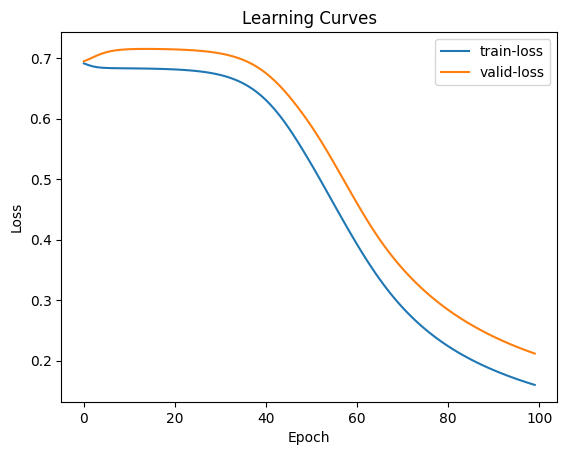

In [7]:
plot_learning_curves(train_loss, valid_loss)

In [8]:
print("test_acc: {:.4f}".format(accuracy_score(model.predict(test_data[:, 1:]), test_data[:, 0:1])))

test_acc: 0.9550


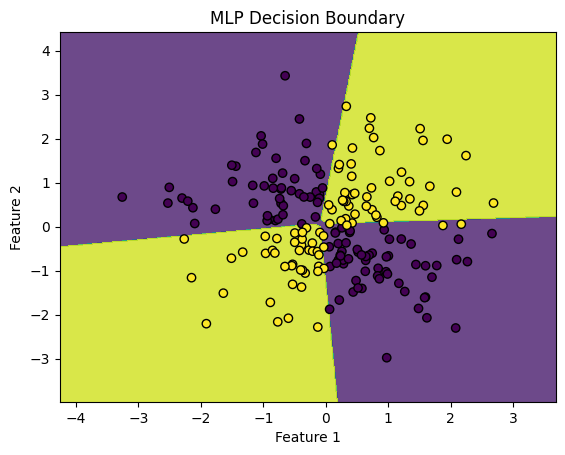

In [9]:
plot_decision_boundary(model, test_data[:, 1:], test_data[:, 0:1])

### 1.2 Center Surround

In [10]:
train_data, valid_data, test_data = make_data('center_surround', "./datasets", False)
model, train_loss, valid_loss = train_mlp(
    (train_data, valid_data), 10, 1e-1, 20, criterian='bce'
)

Epoch: 5 - valid_acc: 0.7250
Epoch: 10 - valid_acc: 0.7050
Epoch: 15 - valid_acc: 0.6700
Epoch: 20 - valid_acc: 0.6600
Epoch: 25 - valid_acc: 0.7350
Epoch: 30 - valid_acc: 0.8550
Epoch: 35 - valid_acc: 0.9100
Epoch: 40 - valid_acc: 0.9400
Epoch: 45 - valid_acc: 0.9550
Epoch: 50 - valid_acc: 0.9550
Epoch: 55 - valid_acc: 0.9550
Epoch: 60 - valid_acc: 0.9550
Epoch: 65 - valid_acc: 0.9550
Epoch: 70 - valid_acc: 0.9550
Epoch: 75 - valid_acc: 0.9550
Epoch: 80 - valid_acc: 0.9550
Epoch: 85 - valid_acc: 0.9600
Epoch: 90 - valid_acc: 0.9600
Epoch: 95 - valid_acc: 0.9650
Epoch: 100 - valid_acc: 0.9650


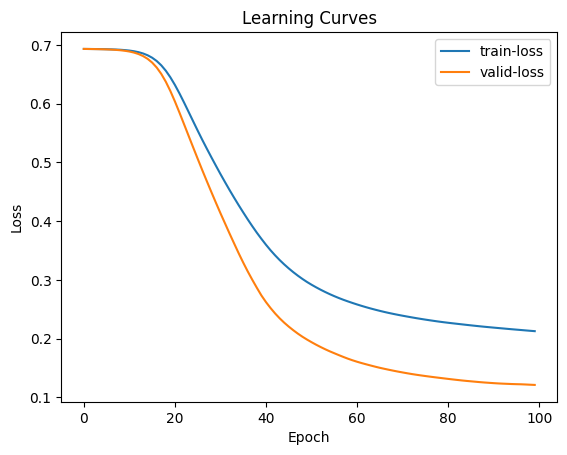

In [11]:
plot_learning_curves(train_loss, valid_loss)

In [12]:
print("test_acc: {:.4f}".format(accuracy_score(model.predict(test_data[:, 1:]), test_data[:, 0:1])))

test_acc: 0.7350


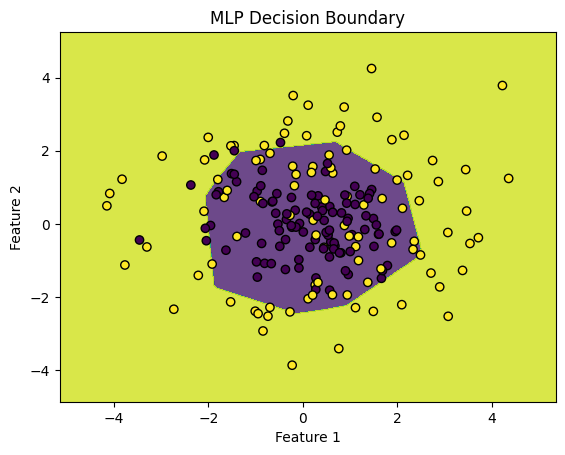

In [13]:
plot_decision_boundary(model, test_data[:, 1:], test_data[:, 0:1])

### 1.3 Spiral

In [14]:
train_data, valid_data, test_data = make_data('spiral', "./datasets", False)
model, train_loss, valid_loss = train_mlp(
    (train_data, valid_data), 10, 1e-1, 20, criterian='bce'
)

Epoch: 5 - valid_acc: 0.7000
Epoch: 10 - valid_acc: 0.7150
Epoch: 15 - valid_acc: 0.7000
Epoch: 20 - valid_acc: 0.7000
Epoch: 25 - valid_acc: 0.6950
Epoch: 30 - valid_acc: 0.7150
Epoch: 35 - valid_acc: 0.7150
Epoch: 40 - valid_acc: 0.7150
Epoch: 45 - valid_acc: 0.7250
Epoch: 50 - valid_acc: 0.7300
Epoch: 55 - valid_acc: 0.7250
Epoch: 60 - valid_acc: 0.7400
Epoch: 65 - valid_acc: 0.7400
Epoch: 70 - valid_acc: 0.7450
Epoch: 75 - valid_acc: 0.7450
Epoch: 80 - valid_acc: 0.7450
Epoch: 85 - valid_acc: 0.7500
Epoch: 90 - valid_acc: 0.7500
Epoch: 95 - valid_acc: 0.7400
Epoch: 100 - valid_acc: 0.7400


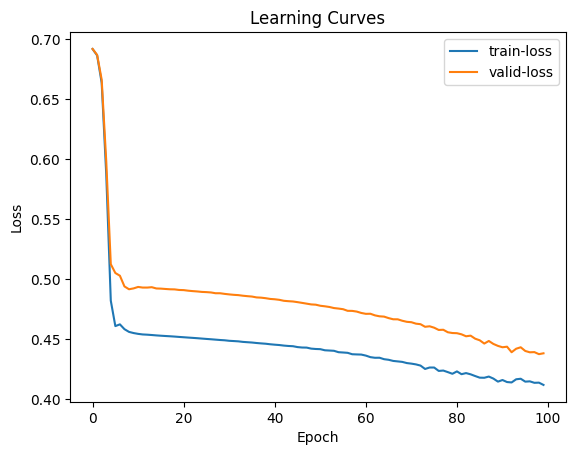

In [15]:
plot_learning_curves(train_loss, valid_loss)

In [16]:
print("test_acc: {:.4f}".format(accuracy_score(model.predict(test_data[:, 1:]), test_data[:, 0:1])))

test_acc: 0.8000


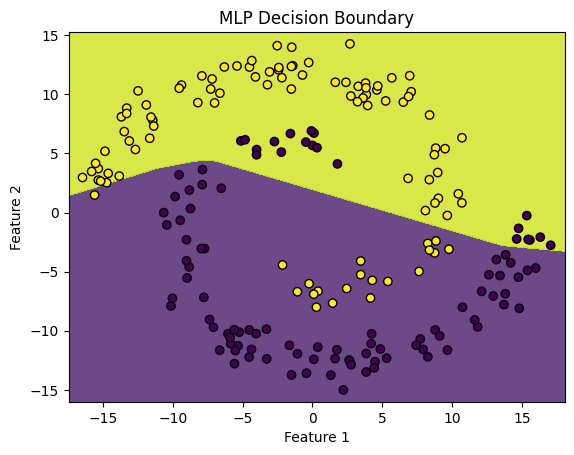

In [17]:
plot_decision_boundary(model, test_data[:, 1:], test_data[:, 0:1])

### 1.4 Two Gasussians

In [18]:
train_data, valid_data, test_data = make_data('two_gaussians', "./datasets", False)
model, train_loss, valid_loss = train_mlp(
    (train_data, valid_data), 10, 1e-1, 20, criterian='bce'
)

Epoch: 5 - valid_acc: 0.7250
Epoch: 10 - valid_acc: 0.8700
Epoch: 15 - valid_acc: 0.9450
Epoch: 20 - valid_acc: 0.9700
Epoch: 25 - valid_acc: 0.9750
Epoch: 30 - valid_acc: 0.9850
Epoch: 35 - valid_acc: 0.9900
Epoch: 40 - valid_acc: 0.9850
Epoch: 45 - valid_acc: 0.9800
Epoch: 50 - valid_acc: 0.9800
Epoch: 55 - valid_acc: 0.9800
Epoch: 60 - valid_acc: 0.9800
Epoch: 65 - valid_acc: 0.9800
Epoch: 70 - valid_acc: 0.9800
Epoch: 75 - valid_acc: 0.9800
Epoch: 80 - valid_acc: 0.9800
Epoch: 85 - valid_acc: 0.9800
Epoch: 90 - valid_acc: 0.9800
Epoch: 95 - valid_acc: 0.9800
Epoch: 100 - valid_acc: 0.9800


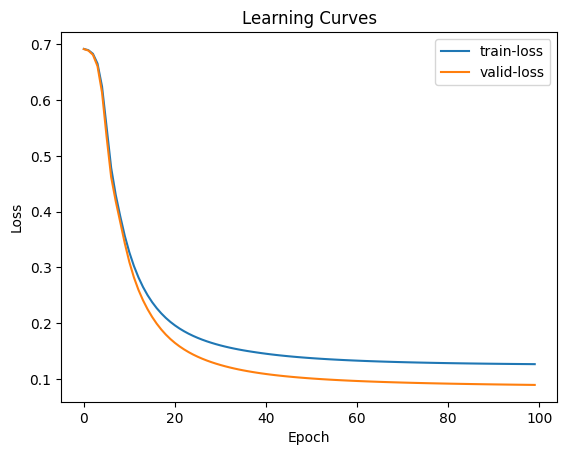

In [19]:
plot_learning_curves(train_loss, valid_loss)

In [20]:
print("test_acc: {:.4f}".format(accuracy_score(model.predict(test_data[:, 1:]), test_data[:, 0:1])))

test_acc: 0.9100


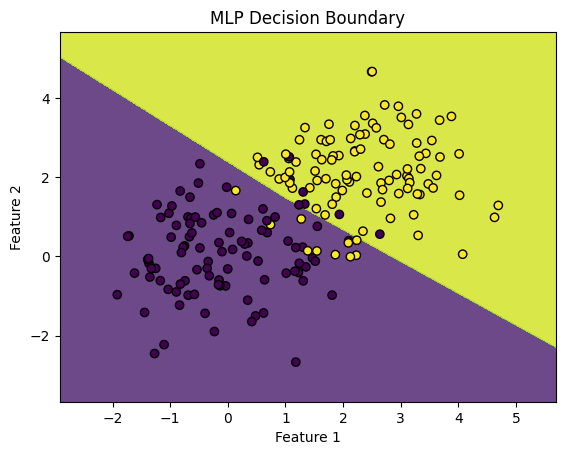

In [21]:
plot_decision_boundary(model, test_data[:, 1:], test_data[:, 0:1])

## Step 2

Hyper-parameters

- Learning Rate: 1e-1
- Number of Hidden Nodes: 10
- Batch Size: 20 (5 for XOR)
- Epochs: 100
- SGD Momentum: 0.9
- Shuffle Dataset: True
- Objective Function: MSE

Oberservations:

  - When using MSE, a significant decrease of accuracy for XOR is observed (same hyper-parameters setting as BCE). The The accuracy on XOR can be improved by reducing the batchsize from 20 to 5.
  - No significant degradation of model performance on other datasets was found.

### 2.1 XOR

In [22]:
train_data, valid_data, test_data = make_data('xor', "./datasets", False)
model, train_loss, valid_loss = train_mlp(
    (train_data, valid_data), 10, 1e-1, 10, criterian='mse'
)

Epoch: 5 - valid_acc: 0.4550
Epoch: 10 - valid_acc: 0.4550
Epoch: 15 - valid_acc: 0.4550
Epoch: 20 - valid_acc: 0.4550
Epoch: 25 - valid_acc: 0.4550
Epoch: 30 - valid_acc: 0.4550
Epoch: 35 - valid_acc: 0.5350
Epoch: 40 - valid_acc: 0.6250
Epoch: 45 - valid_acc: 0.6500
Epoch: 50 - valid_acc: 0.6650
Epoch: 55 - valid_acc: 0.6850
Epoch: 60 - valid_acc: 0.7800
Epoch: 65 - valid_acc: 0.8550
Epoch: 70 - valid_acc: 0.8600
Epoch: 75 - valid_acc: 0.8750
Epoch: 80 - valid_acc: 0.9100
Epoch: 85 - valid_acc: 0.9350
Epoch: 90 - valid_acc: 0.9450
Epoch: 95 - valid_acc: 0.9550
Epoch: 100 - valid_acc: 0.9600


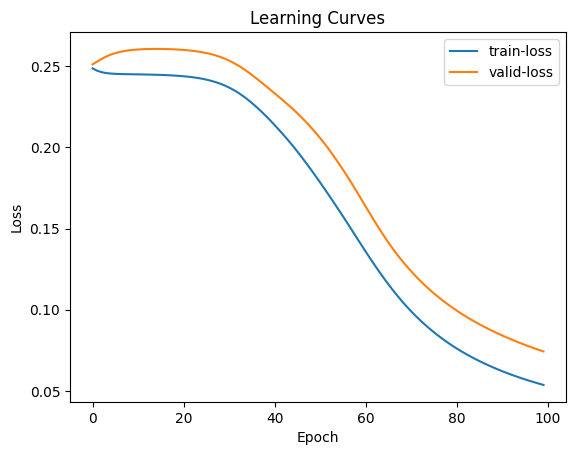

In [23]:
plot_learning_curves(train_loss, valid_loss)

In [24]:
print("test_acc: {:.4f}".format(accuracy_score(model.predict(test_data[:, 1:]), test_data[:, 0:1])))

test_acc: 0.9650


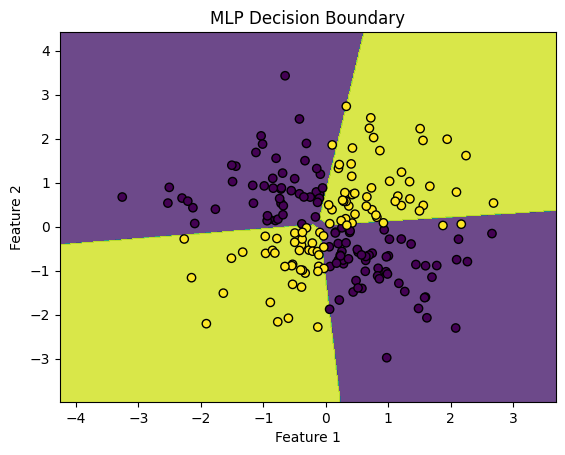

In [25]:
plot_decision_boundary(model, test_data[:, 1:], test_data[:, 0:1])

### 2.2 Center Surround

In [26]:
train_data, valid_data, test_data = make_data('center_surround', "./datasets", False)
model, train_loss, valid_loss = train_mlp(
    (train_data, valid_data), 10, 1e-1, 20, criterian='mse'
)

Epoch: 5 - valid_acc: 0.6500
Epoch: 10 - valid_acc: 0.8900
Epoch: 15 - valid_acc: 0.7950
Epoch: 20 - valid_acc: 0.7350
Epoch: 25 - valid_acc: 0.7050
Epoch: 30 - valid_acc: 0.7250
Epoch: 35 - valid_acc: 0.7350
Epoch: 40 - valid_acc: 0.7350
Epoch: 45 - valid_acc: 0.7850
Epoch: 50 - valid_acc: 0.8550
Epoch: 55 - valid_acc: 0.9050
Epoch: 60 - valid_acc: 0.9300
Epoch: 65 - valid_acc: 0.9550
Epoch: 70 - valid_acc: 0.9450
Epoch: 75 - valid_acc: 0.9500
Epoch: 80 - valid_acc: 0.9550
Epoch: 85 - valid_acc: 0.9650
Epoch: 90 - valid_acc: 0.9650
Epoch: 95 - valid_acc: 0.9650
Epoch: 100 - valid_acc: 0.9600


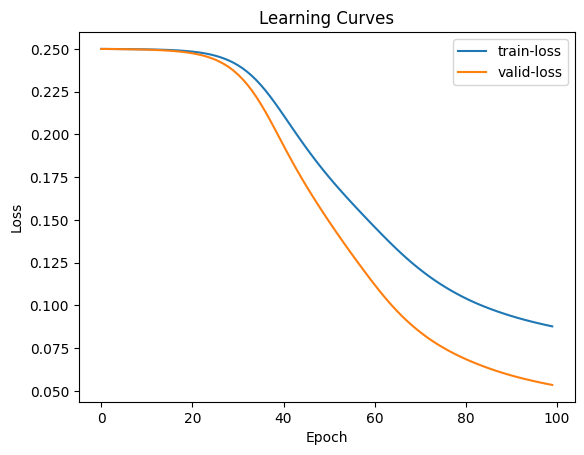

In [27]:
plot_learning_curves(train_loss, valid_loss)

In [28]:
print("test_acc: {:.4f}".format(accuracy_score(model.predict(test_data[:, 1:]), test_data[:, 0:1])))

test_acc: 0.7450


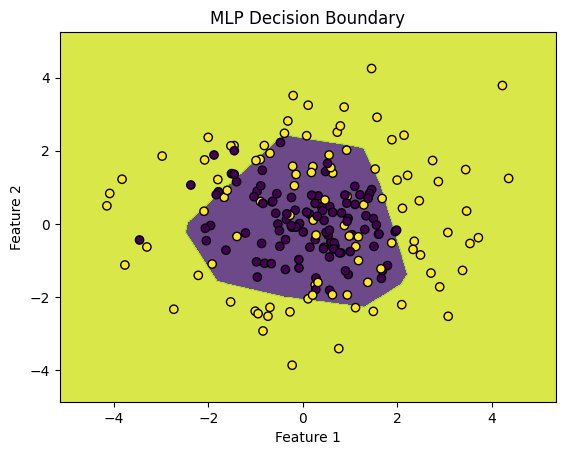

In [29]:
plot_decision_boundary(model, test_data[:, 1:], test_data[:, 0:1])

### 2.3 Spiral

In [30]:
train_data, valid_data, test_data = make_data('spiral', "./datasets", False)
model, train_loss, valid_loss = train_mlp(
    (train_data, valid_data), 10, 1e-1, 20, criterian='mse'
)

Epoch: 5 - valid_acc: 0.7200
Epoch: 10 - valid_acc: 0.7100
Epoch: 15 - valid_acc: 0.7300
Epoch: 20 - valid_acc: 0.7300
Epoch: 25 - valid_acc: 0.7150
Epoch: 30 - valid_acc: 0.7150
Epoch: 35 - valid_acc: 0.7100
Epoch: 40 - valid_acc: 0.7150
Epoch: 45 - valid_acc: 0.7150
Epoch: 50 - valid_acc: 0.7100
Epoch: 55 - valid_acc: 0.7100
Epoch: 60 - valid_acc: 0.7100
Epoch: 65 - valid_acc: 0.7100
Epoch: 70 - valid_acc: 0.7100
Epoch: 75 - valid_acc: 0.7150
Epoch: 80 - valid_acc: 0.7150
Epoch: 85 - valid_acc: 0.7150
Epoch: 90 - valid_acc: 0.7150
Epoch: 95 - valid_acc: 0.7200
Epoch: 100 - valid_acc: 0.7200


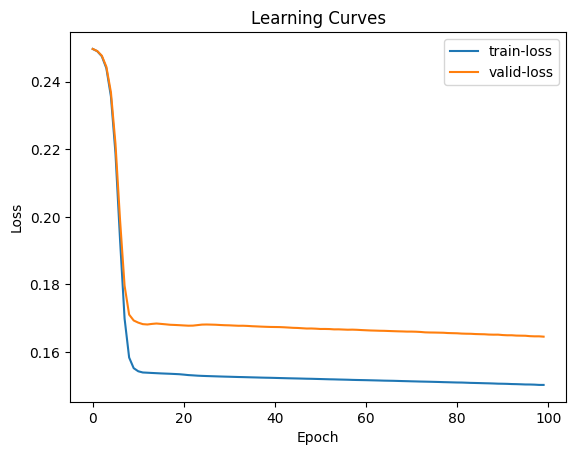

In [31]:
plot_learning_curves(train_loss, valid_loss)

In [32]:
print("test_acc: {:.4f}".format(accuracy_score(model.predict(test_data[:, 1:]), test_data[:, 0:1])))

test_acc: 0.7950


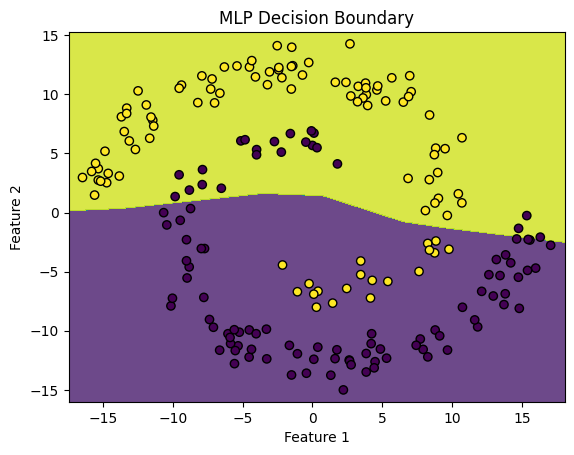

In [33]:
plot_decision_boundary(model, test_data[:, 1:], test_data[:, 0:1])

### 2.4 Two Gaussians

In [34]:
train_data, valid_data, test_data = make_data('two_gaussians', "./datasets", False)
model, train_loss, valid_loss = train_mlp(
    (train_data, valid_data), 10, 1e-1, 20, criterian='mse'
)

Epoch: 5 - valid_acc: 0.5000
Epoch: 10 - valid_acc: 0.7300
Epoch: 15 - valid_acc: 0.7650
Epoch: 20 - valid_acc: 0.9100
Epoch: 25 - valid_acc: 0.9400
Epoch: 30 - valid_acc: 0.9500
Epoch: 35 - valid_acc: 0.9650
Epoch: 40 - valid_acc: 0.9700
Epoch: 45 - valid_acc: 0.9750
Epoch: 50 - valid_acc: 0.9750
Epoch: 55 - valid_acc: 0.9800
Epoch: 60 - valid_acc: 0.9850
Epoch: 65 - valid_acc: 0.9850
Epoch: 70 - valid_acc: 0.9850
Epoch: 75 - valid_acc: 0.9900
Epoch: 80 - valid_acc: 0.9900
Epoch: 85 - valid_acc: 0.9900
Epoch: 90 - valid_acc: 0.9850
Epoch: 95 - valid_acc: 0.9850
Epoch: 100 - valid_acc: 0.9850


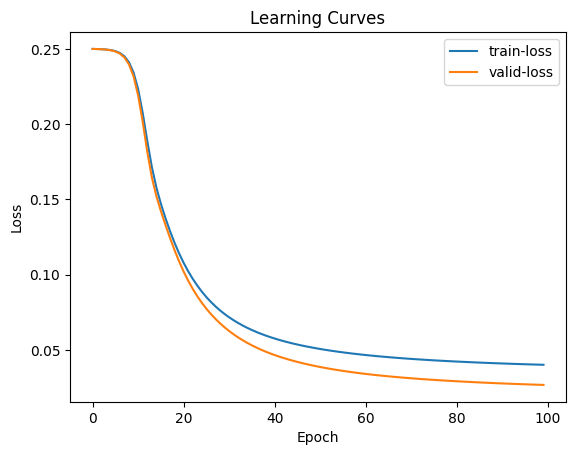

In [35]:
plot_learning_curves(train_loss, valid_loss)

In [36]:
print("test_acc: {:.4f}".format(accuracy_score(model.predict(test_data[:, 1:]), test_data[:, 0:1])))

test_acc: 0.9150


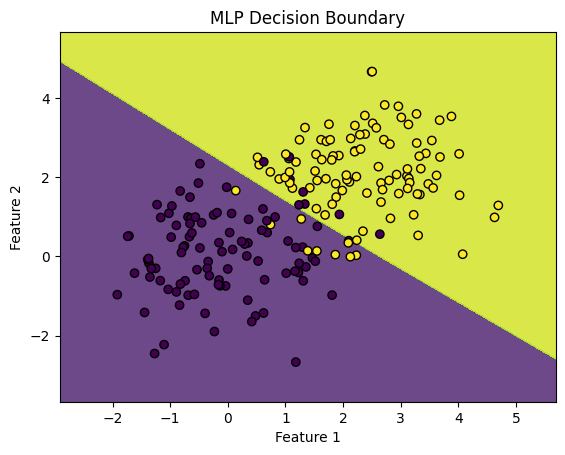

In [37]:
plot_decision_boundary(model, test_data[:, 1:], test_data[:, 0:1])

## Step 3


After Step 1 and Step 2, we observe that model on XOR dataset with hyper-parameters:

- Learning Rate: 1e-1
- Number of Hidden Nodes: 10
- Batch Size: 20 (5 for XOR)
- Epochs: 100
- SGD Momentum: 0.9
- Shuffle Dataset: True
- Objective Function: BCE

have the worst performance.

In [38]:
train_data, valid_data, test_data = make_data('center_surround', "./datasets", False)
model, train_loss, valid_loss = train_mlp(
    (train_data, valid_data), 10, 1e-1, 20, criterian='bce'
)

Epoch: 5 - valid_acc: 0.7200
Epoch: 10 - valid_acc: 0.6950
Epoch: 15 - valid_acc: 0.6500
Epoch: 20 - valid_acc: 0.6350
Epoch: 25 - valid_acc: 0.7000
Epoch: 30 - valid_acc: 0.8150
Epoch: 35 - valid_acc: 0.9200
Epoch: 40 - valid_acc: 0.9500
Epoch: 45 - valid_acc: 0.9550
Epoch: 50 - valid_acc: 0.9600
Epoch: 55 - valid_acc: 0.9650
Epoch: 60 - valid_acc: 0.9700
Epoch: 65 - valid_acc: 0.9650
Epoch: 70 - valid_acc: 0.9650
Epoch: 75 - valid_acc: 0.9650
Epoch: 80 - valid_acc: 0.9650
Epoch: 85 - valid_acc: 0.9650
Epoch: 90 - valid_acc: 0.9650
Epoch: 95 - valid_acc: 0.9650
Epoch: 100 - valid_acc: 0.9650


In [39]:
print("test_acc: {:.4f}".format(accuracy_score(model.predict(test_data[:, 1:]), test_data[:, 0:1])))

test_acc: 0.7450


### 3.1 Decision Boundary of Each Hidden Node

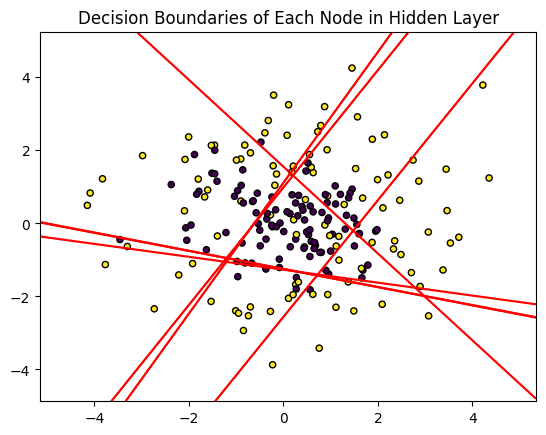

In [40]:
X, y = test_data[:, 1:], test_data[:, 0:1]
plot_hidden_decision_boundary(model, X, y)

### 3.2 Decision Boundary of Train/Valid/Test sets

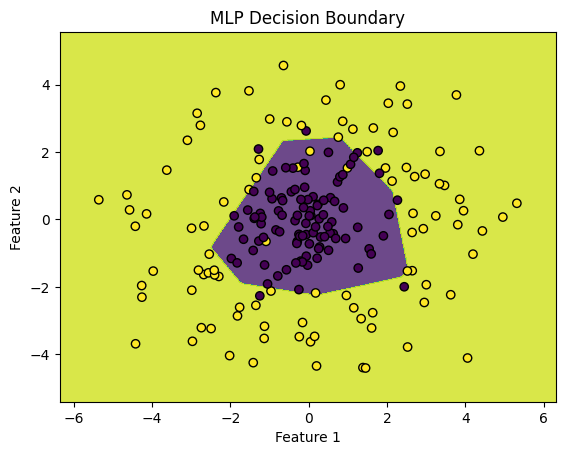

In [41]:
# Train Set
plot_decision_boundary(model, train_data[:, 1:], train_data[:, 0:1])

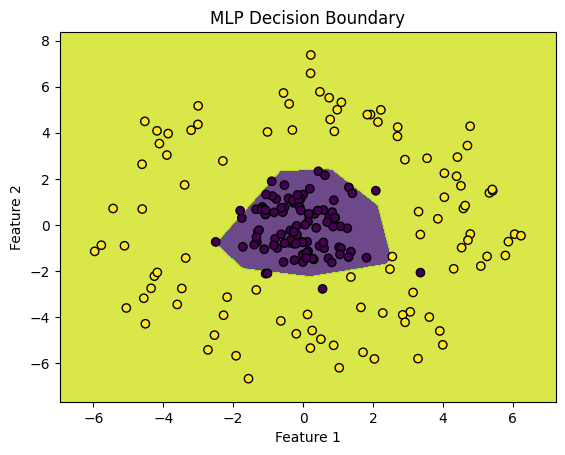

In [42]:
# Valid Set
plot_decision_boundary(model, valid_data[:, 1:], valid_data[:, 0:1])

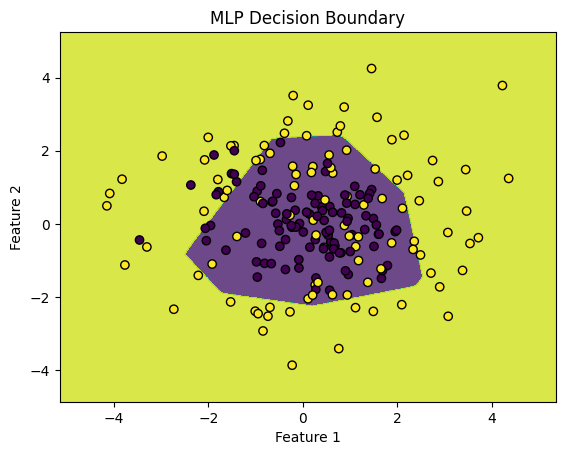

In [43]:
# Test set
plot_decision_boundary(model, test_data[:, 1:], test_data[:, 0:1])

Why we selet this instance:

- We conducted multiple tests on three additional datasets using the same hyperparameters and observed that the model performs the worst on the XOR dataset.

- Furthermore, it was noted that on the XOR dataset, the accuracy on the training and validation sets exceeds 95%, yet it drops to only 75% on the test set. Moreover, no matter how the existing hyperparameters are adjusted, there is no improvement in accuracy on the test set.

Observations and Analysis:

- In the central region of the test dataset, there is considerable label overlap between two categories, which leads to the decision boundaries learned by the model being unable to correctly classify all samples.

- By plotting the decision boundaries of the model on the training, validation, and test sets, we have observed significant inconsistencies in the data distribution between the training/validation sets and the test set.

## Step 4

Approach

- Based on the preceding analysis, we hypothesize that the model's inability to learn more complex decision boundaries is due to it having only a single hidden layer. Consequently, we plan to experiment by increasing the number of hidden layers.

## Step 5

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import SGD

In [71]:
class MLP2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(2, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return F.sigmoid(self.layers(x))

def train_mlp2(
    data: Iterable, lr: float=1e-1, bs: int=20, 
    epochs: int=100, momentum: float=0.9,
    eval_interval: int=5, shuffle: bool=False):
    
    model = MLP2()
    optimizer = SGD(params=model.parameters(), lr=lr, momentum=momentum)
    
    train_data, valid_data = data
    
    for e in range(epochs):
        if shuffle:
            np.random.shuffle(train_data)
        for i in range(train_data.shape[0] // bs):
            batch_inputs = train_data[i*bs:(i+1)*bs, 1:]
            batch_labels = train_data[i*bs:(i+1)*bs, 0:1]
            
            p = model(torch.from_numpy(batch_inputs.astype('float32')))
            loss = F.binary_cross_entropy(p, torch.from_numpy(batch_labels.astype('float32')))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (e+1) % eval_interval == 0:
            print("Epoch: {} - valid_acc: {:.4f}".format(
                e+1, 
                accuracy_score((p.detach().numpy()>0.5).astype('int32'), batch_labels)))
    
    return model


train_data, valid_data, test_data = make_data('center_surround', "./datasets", False)
model = train_mlp2((train_data, valid_data))

Epoch: 5 - valid_acc: 0.9000
Epoch: 10 - valid_acc: 1.0000
Epoch: 15 - valid_acc: 1.0000
Epoch: 20 - valid_acc: 1.0000
Epoch: 25 - valid_acc: 1.0000
Epoch: 30 - valid_acc: 1.0000
Epoch: 35 - valid_acc: 1.0000
Epoch: 40 - valid_acc: 0.9500
Epoch: 45 - valid_acc: 0.9500
Epoch: 50 - valid_acc: 1.0000
Epoch: 55 - valid_acc: 0.9500
Epoch: 60 - valid_acc: 0.9500
Epoch: 65 - valid_acc: 1.0000
Epoch: 70 - valid_acc: 1.0000
Epoch: 75 - valid_acc: 0.9500
Epoch: 80 - valid_acc: 1.0000
Epoch: 85 - valid_acc: 1.0000
Epoch: 90 - valid_acc: 0.9500
Epoch: 95 - valid_acc: 1.0000
Epoch: 100 - valid_acc: 1.0000


In [72]:
p = model(torch.from_numpy(test_data[:, 1:].astype('float32')))
print(accuracy_score((p.detach().numpy()>0.5).astype('int32'), test_data[:, 0:1]))

0.74
